# Unbox the Cox: Why perfect predictors result in large p-values (0.9) ?

## Perfect predictors

If you followed previous posts, we noted that logistic regression has issue fitting perfectly separated data, resulting in infinite odds ratio ($\beta$). In Cox regression, hazard takes the place of odds so you may be wondering if there is a similar issue with perfect predictors. The answer is "Yes", however as opposed to logistic regression, it is much less obvious how this occurs here and what even "perfect predictors" would be.

Perfect predictors in Cox regression are predictors $x$ whose ranks exactly match ranks of event times (their Spearman correlation = 1). In a previous part, we created a made-up dataset with 5 subjects, where a single predictor $x$ could be the dosage of the drug that helps people live longer. To make $x$ a perfect predictor of event times, we swap event times for subjects C and D:

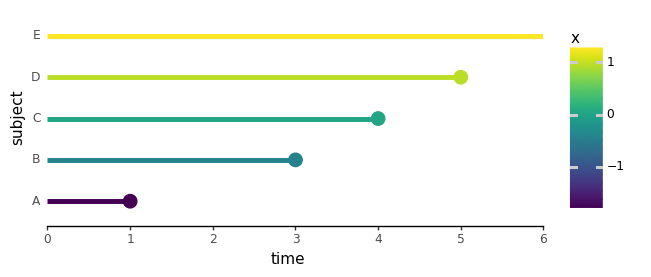

<ggplot: (333970117)>

In [2]:
import numpy as np
import pandas as pd
import plotnine as p9

from cox.plots import (
    plot_subject_event_times,
    animate_subject_event_times_and_mark_at_risk,
    plot_cost_vs_beta,
)


perfect_df =  pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E'],
    'time': [1, 3, 4, 5, 6],
    'event': [1, 1, 1, 1, 0],
    'x': [-1.7, -0.4, 0.0, 0.9, 1.2],
	# 'x': [0.7, 1.4, 2.0, 2.9, 3.2],
})

plot_subject_event_times(perfect_df, color_map='x')

In [3]:
animate_subject_event_times_and_mark_at_risk(
    perfect_df, color_map='x'
).save('../images/cox_likelihood_fitting_perfect.gif')

![animated_likelihood_fitting](../images/cox_likelihood_fitting_perfect.gif)

In order to understand why these "perfect predictors" can be problematic, we continue where we left off last time and plot negative log-likelihood cost vs $\beta$:

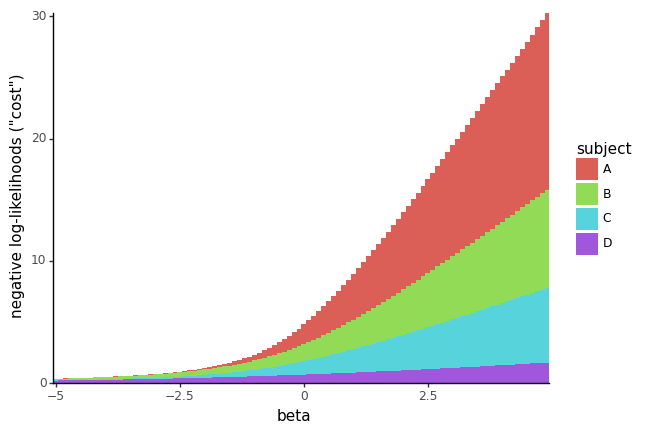

<ggplot: (334138843)>

In [4]:
def event_time_and_x_from_subject(df, subject):
    subject_with_event_df = df.query(f"subject == '{subject}' & event == 1")
    if subject_with_event_df.empty: # For censored subjects return infinite time
        return (np.inf, 0)
    return subject_with_event_df.iloc[0][['time', 'x']]

def subjects_at_risk_data(df, subject):
    time = event_time_and_x_from_subject(df, subject)[0]
    return df.query(f'time >= {time}')

def log_likelihood(df, subject, beta):
    x_subjects_at_risk = subjects_at_risk_data(df, subject)['x']
    x_subject = event_time_and_x_from_subject(df, subject)[1]
    at_risk_hazards = np.exp(beta * x_subjects_at_risk)
    return beta * x_subject - np.log(np.sum(at_risk_hazards))

def neg_log_likelihood_for_all_subjects(df, beta):
    subjects = df.query("event == 1")['subject'].tolist()
    neg_log_likelihoods = [-log_likelihood(df, subject, beta) for subject in subjects]
    return pd.DataFrame({
        'subject': subjects,
        'neg_log_likelihood': neg_log_likelihoods
    })

def neg_log_likelihood_all_subjects_sweep_betas(df, betas=np.arange(-5, 5, 0.1)):
    loglikelihoods_per_beta = []
    for beta in betas:
        beta_df = neg_log_likelihood_for_all_subjects(df, beta)
        beta_df.insert(0, 'beta', beta) # Add beta column
        loglikelihoods_per_beta.append(beta_df)
    return pd.concat(loglikelihoods_per_beta)

negloglik_sweep_betas_perfect_df = neg_log_likelihood_all_subjects_sweep_betas(
    perfect_df,
    betas=np.arange(-5, 5, 0.1)
)
plot_cost_vs_beta(negloglik_sweep_betas_perfect_df, width=0.1)

We can see immediately that now there is no minimum value of $\beta$: arbitrarily large negative values of $\beta$ result in arbitrarily good log-likelihood fits for all events.

Let's first try to understand mathematically why this happens, by writing down the likelihood of event A, and inspect how numerator and denumerator change with $\beta$:

$$L_A = \frac{h_A}{h_A + h_B + h_C + h_D + h_E} = \frac{e^{-1.7\beta}}{e^{-1.7\beta} + e^{-0.4\beta} + e^{0\beta} + e^{0.9\beta} + e^{1.2\beta}}$$

When $\beta$ is high or a large _positive_ number, the **last** term in the denumerator (with largest $x = 1.2$), hazard of subject E, dominates the entire denumerator and becomes very large. Therefore, the likelihood becomes small and approaches zero:

$$L_A (\mathrm{large\ positive\ \beta}) \approx \frac{e^{-1.7\beta}}{e^{1.2\beta}} = e^{(-1.7 + 1.2)\beta} = e^{-0.5\beta} \rightarrow 0$$

resulting in a large negative log-likelihood. The exact same thing happens for every other individual likelihood since the individual hazards (numerators) of all likelihoods are smaller than the last one. That is why the cost or negative log-likelihoods increase for subjects A to D. High $\beta$ here _simulatenously decreases_ all likelihoods and creates poor fits of all events. This is understandable, as subjects with larger $x$ experience events later - the effect of $x$ is to prolong time to event.

When $\beta$ is low or a large _negative_ number, the **first** term in the denumerator, hazard of the subject A, dominates since it has the lowest value of $x$. As the same hazard of subject A also appears in the numerator, the likelihood $L_A$ can be arbitrarily close to 1 by making $\beta$ increasingly negative, which creates almost perfect fit:

$$L_A (\mathrm{large\ negative\ \beta}) \approx \frac{e^{-1.7\beta}}{e^{-1.7\beta}} = 1$$

The exact same thing happens to every other individual likelihood: negative $\beta$ s now simulatenously _increase likelihoods_ of all events. In other words, there are no trade-offs to having a negative $\beta$. Meanwhile, some individual hazards increase (subjects A and B that with negative $x$), some stay constant (subject C with $x = 0$) and some decrease (subject D with positive $x$). But as mentioned before, the absolute values of $x$ do not really matter - fitting is performed on likelihoods, which are _ratios of hazards_.

If $x$ had a perfect negative Spearman correlation (-1) with event times, then things would be reversed: now arbitrarily positive $\beta$ s would create arbitrarily good fits.

The way likelihoods are constructed, as ratio of a hazard to the sum of hazards of all subjects still at risk, means that we will have negative $\beta$ creating perfect fit for likelihood of each subject whose **event time rank is greater than or equal to predictor rank** !

We can check this visually and illustrate what happens when event time ranks and predictor ranks mismatch on a new made-up example:

In [35]:
sample_df = pd.DataFrame({
    'subject': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'x': [-1.7, -0.4, 0.0, 0.5, 0.9, 1.2, 1.3, 1.45],
    'time': [1, 2, 4, 3, 5, 7, 6, 8],
    'x_rank': [1, 2, 3, 4, 5, 6, 7, 8],
    'event': [1, 1, 1, 1, 1, 1, 1, 0],
})
sample_df['time_rank_lower_than_x_rank'] = sample_df['time'] < sample_df['x_rank']

sample_df

,subject,x,time,x_rank,event,time_rank_lower_than_x_rank
0,A,-1.70,1,1,1,False
1,B,-0.40,2,2,1,False
2,C,0.00,4,3,1,False
3,D,0.50,3,4,1,True
4,E,0.90,5,5,1,False
5,F,1.20,7,6,1,False
6,G,1.30,6,7,1,True
7,H,1.45,8,8,0,False


In this example, `time` column is 1 to 8, so its value is also its rank, and `x_rank` is a ranking of predictors $x$. Notice that for subjects D and G, `x_rank` is greater than `time`. Therefore, the likelihoods of D and G will not have the cancellation of numerator and denumerator for large negative values of $\beta$:

$$L_D = \frac{h_D}{h_C + h_D + \cdots + h_H} = \frac{e^{0.5\beta}}{e^{0\beta} + e^{0.5\beta} + \cdots + e^{1.45\beta}}$$

$$L_D (\mathrm{large\ negative\ \beta}) \approx \frac{e^{0.5\beta}}{e^{0\beta}} = e^{0.5\beta} \rightarrow 0$$

 Their likelihoods will now be maximal at some intermediate values of $\beta$. We can plot individual likelihoods to visualize this:

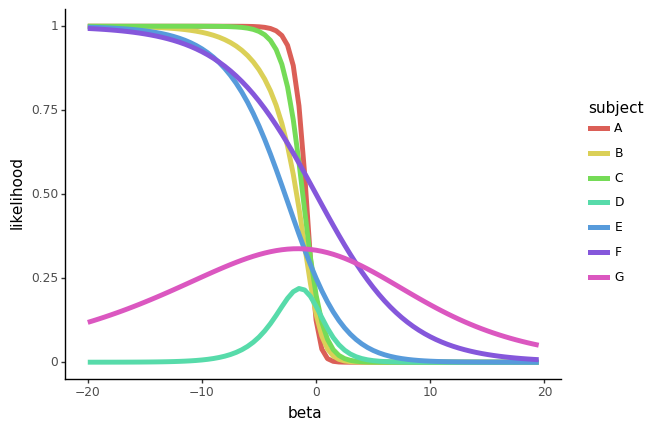

<ggplot: (335937533)>

In [37]:
def plot_likelihoods(df, ylim=[-20, 20]):
    betas = np.arange(ylim[0], ylim[1], 0.5)
    subjects = df.query("event == 1")['subject'].tolist()
    likelihoods_per_subject = []
    for subject in subjects:
        likelihoods = [
            np.exp(log_likelihood(df, subject, beta))
            for beta in betas
        ]
        likelihoods_per_subject.append(
            pd.DataFrame({
                'beta': betas,
                'likelihood': likelihoods,
                'subject': [subject] * len(betas),
            })        
        )
    lik_df = pd.concat(likelihoods_per_subject)
    return (
        p9.ggplot(lik_df, p9.aes('beta', 'likelihood', color='subject'))
        + p9.geom_line(size=2)
        + p9.theme_classic()
    )    

plot_likelihoods(sample_df)

## Fitting perfect predictors

How do perfect predictors behave in practice? We will again use lifelines library to investigate:

In [15]:
from lifelines import CoxPHFitter

perfect_cox_model = CoxPHFitter()
perfect_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_cox_model.print_summary()

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1586: ConvergenceWarning: The log-likelihood is getting suspiciously close to 0 and the delta is still large. There may be complete separation in the dataset. This may result in incorrect inference of coefficients. See https://stats.stackexchange.com/q/11109/11867 for more.

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/utils/__init__.py:1165: ConvergenceWarning: Column x has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

/Users/igor/Library/Caches/pypoetry/virtualenvs/blog-HRL7VYfp-py3.10/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1611: ConvergenceWarning: Newton-Rhaphson failed to con

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -0.00
         time fit was run = 2023-06-24 05:25:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x         -31.95       0.00     388.11          -792.62           728.73                 0.00                  inf

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -0.08 0.93       0.10
---
Concordance = 1.00
Partial AIC = 2.00
log-likelihood ratio test = 9.57 on 1 df
-log2(p) of ll-ratio test = 8.99

Similarly to logistic regression, we get convergence warnings and very large confidence intervals for our predictor (coefficient) $\beta$, resulting in a p-value of 0.93.

According to the lifeline's documentation and the StackOverflow links that are listed in these warnings, one way to deal with this type of convergence issue is to add a regularization term to the cost function. This term increases the cost for large values of coefficients and L2 regularization can be activated by setting `penalizer` argument to a value greater than zero:

In [16]:
perfect_pen_cox_model = CoxPHFitter(penalizer=0.01, l1_ratio=0)
perfect_pen_cox_model.fit(perfect_df, duration_col='time', event_col='event', formula='x')
perfect_pen_cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 5 total observations, 1 right-censored observations>
             duration col = 'time'
                event col = 'event'
                penalizer = 0.01
                 l1 ratio = 0
      baseline estimation = breslow
   number of observations = 5
number of events observed = 4
   partial log-likelihood = -1.01
         time fit was run = 2023-06-24 05:25:54 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
x          -3.56       0.03       2.25            -7.97             0.85                 0.00                 2.35

            cmp to     z    p   -log2(p)
covariate                               
x             0.00 -1.58 0.11       3.13
---
Concordance = 1.00
Partial AIC = 4.01
log-likelihood ratio test = 7.56 on 1 df
-log2(p) of ll-ratio test = 7.39

As we can see, while this does resolve the convergence warning, it does little to address large confidence intervals, and the corresponding p-values. Here, the p-value of a perfect predictor is still fairly large, 0.11.